In [1]:
import imghdr
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [4]:
data_dir=r"D:\NullClass"
extensions=['jpeg','jpg','bmp','png']

In [5]:
os.listdir(data_dir)

['mouth open', 'mouth shut']

In [6]:
print(len(os.listdir(os.path.join(data_dir,'mouth open')))) #All the files in mouth open

249


In [7]:
print(len(os.listdir(os.path.join(data_dir,'mouth shut'))))

241


In [8]:
def clean_images(data_dir,extensions):
    for image_class in os.listdir(data_dir):
        for image in os.listdir(os.path.join(data_dir,image_class)):
            image_path=os.path.join(data_dir,image_class, image)
            try:
                img=cv2.imread(image_path)
                tip=imghdr.what(image_path)
                if tip not in extensions:
                    print("Image not in extensions list {}".format(image_path))
                    os.remove(image_path)
            except Exception as e:
                print("Issue with image{}".format(image_path))

In [9]:
from pathlib import Path
image_extensions=['.jpeg','.jpg','.bmp','.png']

img_type_accepted_by_tf=["bmp","gif","jpeg","png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type= imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by tensorflow")

In [10]:
clean_images(data_dir,extensions)

In [11]:
print(len(os.listdir(os.path.join(data_dir,'mouth open'))))
print(len(os.listdir(os.path.join(data_dir,'mouth shut'))))

249
241


### Loading the data

In [12]:
tf.data.Dataset.list_files

<function tensorflow.python.data.ops.dataset_ops.DatasetV2.list_files(file_pattern, shuffle=None, seed=None, name=None)>

In [13]:
data= tf.keras.utils.image_dataset_from_directory(r"D:\NullClass")

Found 490 files belonging to 2 classes.


In [14]:
data=data.map(lambda x,y:(x/255.0,y))
print(len(data))

16


In [15]:
train_size=int(len(data)*0.7)
val_size=int(len(data)*0.2)
test_size=int(len(data)*0.1)+1
print(train_size,val_size,test_size)

11 3 2


In [16]:
train=data.take(train_size)
val=data.skip(train_size).take(val_size)
test=data.skip(train_size+val_size).take(test_size)

#### Model

In [17]:
model=Sequential()
model.add(Conv2D(16,(3,3),strides=1,activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(64,(3,3),strides=1,activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128,(3,3),strides=1,activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),strides=1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [18]:
model.compile('adam',loss=tf.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      9280      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

In [20]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [21]:
hist=model.fit(train,epochs=25,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/25
11/11 [==============================] - 11s 779ms/step - loss: 0.7370 - accuracy: 0.4915 - val_loss: 0.6916 - val_accuracy: 0.5312
Epoch 2/25
11/11 [==============================] - 9s 764ms/step - loss: 0.6907 - accuracy: 0.5511 - val_loss: 0.6830 - val_accuracy: 0.6042
Epoch 3/25
11/11 [==============================] - 9s 753ms/step - loss: 0.6700 - accuracy: 0.5767 - val_loss: 0.6603 - val_accuracy: 0.5104
Epoch 4/25
11/11 [==============================] - 9s 760ms/step - loss: 0.6534 - accuracy: 0.6534 - val_loss: 0.5645 - val_accuracy: 0.7292
Epoch 5/25
11/11 [==============================] - 10s 803ms/step - loss: 0.5760 - accuracy: 0.6903 - val_loss: 0.5874 - val_accuracy: 0.7812
Epoch 6/25
11/11 [==============================] - 9s 743ms/step - loss: 0.5475 - accuracy: 0.7557 - val_loss: 0.5958 - val_accuracy: 0.6250
Epoch 7/25
11/11 [==============================] - 9s 756ms/step - loss: 0.5530 - accuracy: 0.7301 - val_loss: 0.4858 - val_accuracy: 0.7812
Epoc

In [22]:
pre=Precision()
re=Recall()
acc=BinaryAccuracy()

In [23]:
for batch in test.as_numpy_iterator():
    X,y=batch
    yhat=model.predict(X)
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)
print("Precision:", pre.result().numpy())
print("Recall:", re.result().numpy())
print("Accuracy:", acc.result().numpy())

1/1 [==============================] - 0s 162ms/step
Precision: 1.0
Recall: 1.0
Accuracy: 1.0


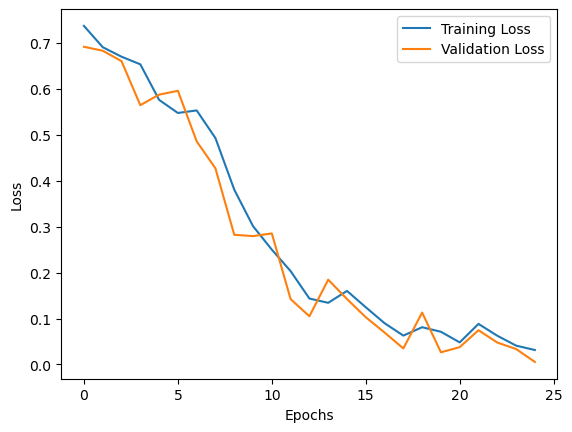

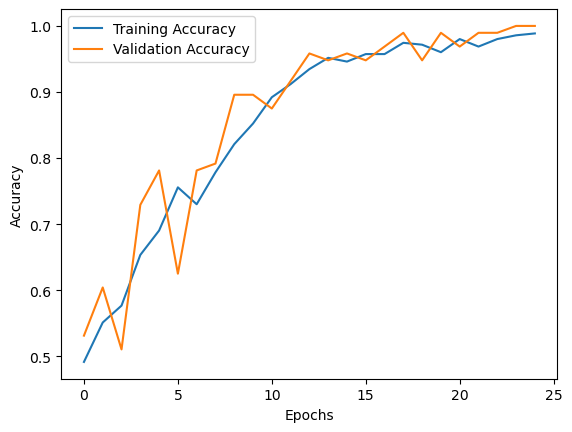

In [24]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

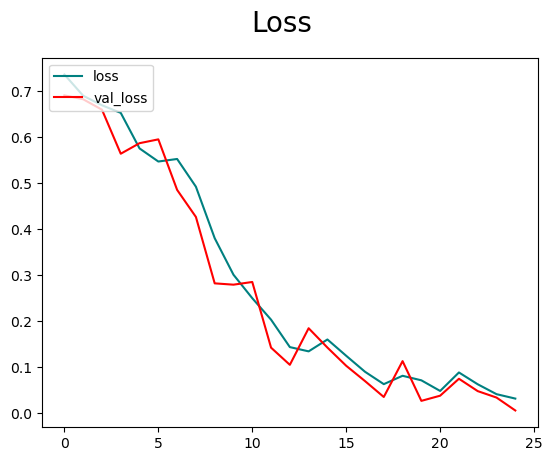

In [25]:
fig=plt.figure()
plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='red',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc="upper left")
plt.show()

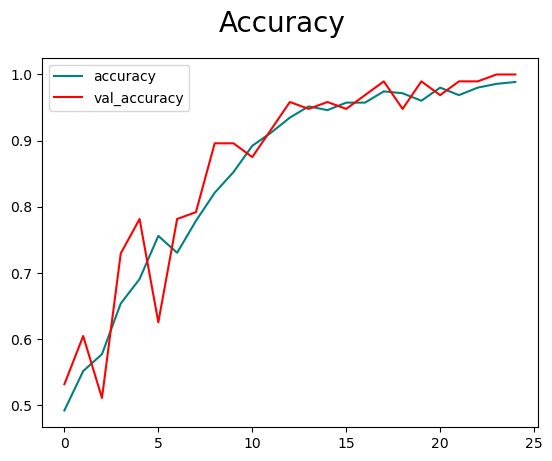

In [26]:
fig=plt.figure()
plt.plot(hist.history['accuracy'],color='teal',label='accuracy')
plt.plot(hist.history['val_accuracy'],color='red',label='val_accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [27]:
from tensorflow.keras.models import load_model
model.save(os.path.join('models','imgclassifier.h5'))

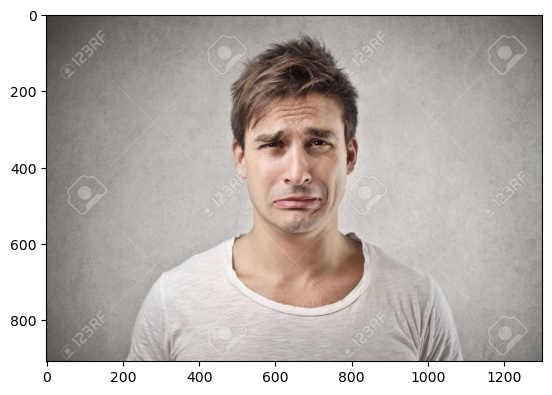

In [28]:
img = cv2.imread(r"C:\Users\PRATHAMESH MANDIYE\OneDrive\Desktop\Testing\sadtestt.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [45]:
def classify_image(image_path):
    # Load the trained model
    model = tf.keras.models.load_model(os.path.join('models','imgclassifier.h5'))  # Replace with your model path

    # Load and preprocess an image using cv2
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))
    image = image.astype(np.float32) / 255.0

    # Make a prediction
    prediction = model.predict(np.expand_dims(image, axis=0))

    # Interpret the prediction
    if prediction[0] <= 0.00005:
        print(prediction[0])
        return "Open"
    else:
        print(prediction[0])
        return "Close"

# Example Usage - Classify an Image
image_path_to_classify = r"C:\Users\PRATHAMESH MANDIYE\OneDrive\Desktop\Testing\sadtestt.jpg"#r"D:\ML(imp)\NOtes and projecTS\Image classification\sadtestt.jpg"
result = classify_image(image_path_to_classify)
print(f"Predicted: {result}")

1/1 [==============================] - 0s 112ms/step
[0.0633549]
Predicted: Close


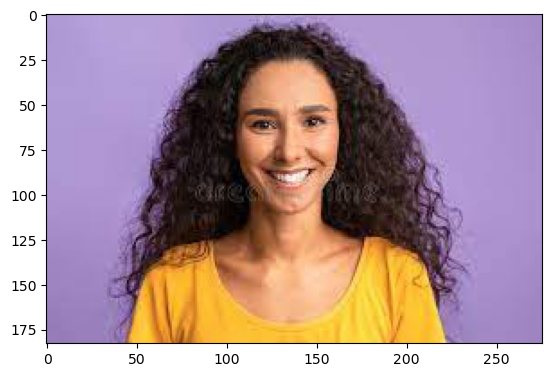

In [46]:
img = cv2.imread(r"C:\Users\PRATHAMESH MANDIYE\OneDrive\Desktop\Testing\happyperson.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [47]:
image_path_to_classify = r"C:\Users\PRATHAMESH MANDIYE\OneDrive\Desktop\Testing\happyperson.jpg"#r"D:\ML(imp)\NOtes and projecTS\Image classification\sadtestt.jpg"
result = classify_image(image_path_to_classify)
print(f"Predicted: {result}")

1/1 [==============================] - 0s 106ms/step
[0.00043516]
Predicted: Close


In [48]:
image_path_to_classify=r"C:\Users\PRATHAMESH MANDIYE\OneDrive\Desktop\open-mouth-man-wide-32890592.jpg"
result=classify_image(image_path_to_classify)
print(f"Predicted:{result}")

1/1 [==============================] - 0s 147ms/step
[0.00189009]
Predicted:Close


In [49]:
image_path_to_classify=r"C:\Users\PRATHAMESH MANDIYE\OneDrive\Desktop\young-man-with-open-mouth-and-large-eyes-DJ4ABY.jpg"
result=classify_image(image_path_to_classify)
print(f"Predicted:{result}")

1/1 [==============================] - 0s 113ms/step
[7.326455e-05]
Predicted:Close
